In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 24a : 
## Working with PyTorch - Lecture
- Flowers DataSet with common transformation
- ${ReLU}$ activation function
- Regularizations:
    - L2, 
    - BatchNorm,
    - Dropout, 
    - Early Stopping

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

# New
from torchsummary import summary
from torchvision import datasets, transforms


In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 41 # number of epochs

BATCH_SIZE = 32

ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.8
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [5]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Helper Functions

In [7]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_torch_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with five columns
                First column need to be epoch, 'x' values
    '''
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor=facecolor, alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1,y2], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1][y1],
                           loss_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            verticalalignment='top', 
            bbox=props)
    
    # Mark arrow at lowest
    offset = (best[y2].max() - best[y2].max())/10
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracy
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1][y3],
                           loss_df.iloc[-1][y4]) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, 
            transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    offset = (best[y4].max() - best[y4].min())/10
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y3.capitalize())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Read Flowers data set

In [8]:
###---------------
### Transformation
###---------------

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [9]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [10]:
dataset_size = len(dataset)

test_size = int(TEST_SIZE*dataset_size) # 22*32

train_size = dataset_size - test_size
print (dataset_size, train_size, test_size)

3670 2936 734


In [11]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:-test_size])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[-test_size:])

In [12]:
class_names = train_dataset.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
numClasses = len(class_names)
numClasses

5

In [14]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

## Data Loader

In [15]:
#torch.utils.data.DataLoader?

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

91 22


In [17]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0))

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means
    
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)

torch.Size([32, 3, 188, 188]) torch.Size([32])


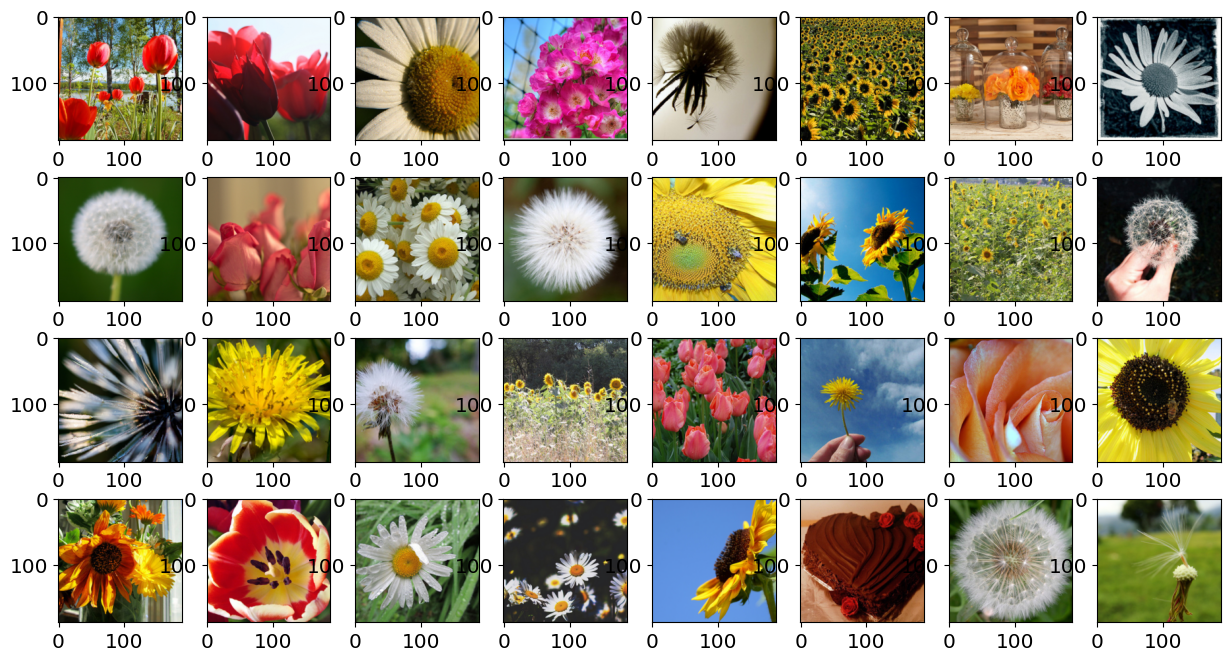

In [18]:
images, labels =next(iter(train_dataloader))

print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

## CNN Model

In [19]:
outChannels1 = 64
outChannels2 = 128
outChannels3 = 256
outChannels4 = 512
outChannels5 = 512
outChannels6 = 1024

numChannels = 3 ### Hard coded

model = nn.Sequential(

    ###------
    ### Set I
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=numChannels, out_channels=outChannels1,
              kernel_size= (3,3),
              padding = 'same'), # 188 x 188 x 64
    
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), #94 x 94 x 64
    
    
    ###------
    ### Set II
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=outChannels1, out_channels=outChannels2,
              kernel_size= (3,3)), # 92 x 92 x 128
    
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), #46 x 46 x 128
    
    ###------
    ### Set III
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=outChannels2, out_channels=outChannels3,
              kernel_size= (3,3)), # 44 x 44 x 256
    
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), #22 x 22 x 256
    
    ###------
    ### Set IV
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=outChannels3, out_channels=outChannels4,
              kernel_size= (3,3)), #  20 x 20 x 512
    
    #nn.BatchNorm2d(outChannels4)
    
    nn.ReLU(inplace=True),

    #nn.Dropout(drop_out_rate)
    
    nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), # 10 x 10 x 512
    
    ###------
    ### Set V
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=outChannels4, out_channels=outChannels5,
              kernel_size= (3,3)), #  8 x 8 x 256
    
    nn.ReLU(inplace=True),

    nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), # 4 x 4 x 512


    ###------
    ### Set VI
    ###------
    ## Conv2d ==> ReLU ==> MaxPool2d
    nn.Conv2d(in_channels=outChannels5, out_channels=outChannels6,
              kernel_size= (3,3)), #  2 x 2 x 1024
    
    nn.ReLU(inplace=True),
    
    ###------
    ### Head
    ###------
    nn.Flatten(),

    nn.Linear( in_features= 2 * 2 *outChannels6, out_features=outChannels6//2),
    
    nn.ReLU(inplace=True),

    nn.Linear( in_features= outChannels6//2, out_features=numClasses),            
 )

In [20]:
model = model.to(device)
print (model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (16): ReLU(inplace=True)


In [21]:
#list(model.parameters())

In [22]:
# for data in train_dataloader:
#     print (data)

In [23]:
_ = summary(model, (3, 188, 188))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 188, 188]        1,792
├─ReLU: 1-2                              [-1, 64, 188, 188]        --
├─MaxPool2d: 1-3                         [-1, 64, 94, 94]          --
├─Conv2d: 1-4                            [-1, 128, 92, 92]         73,856
├─ReLU: 1-5                              [-1, 128, 92, 92]         --
├─MaxPool2d: 1-6                         [-1, 128, 46, 46]         --
├─Conv2d: 1-7                            [-1, 256, 44, 44]         295,168
├─ReLU: 1-8                              [-1, 256, 44, 44]         --
├─MaxPool2d: 1-9                         [-1, 256, 22, 22]         --
├─Conv2d: 1-10                           [-1, 512, 20, 20]         1,180,160
├─ReLU: 1-11                             [-1, 512, 20, 20]         --
├─MaxPool2d: 1-12                        [-1, 512, 10, 10]         --
├─Conv2d: 1-13                           [-1, 512, 8, 8]          

In [24]:
loss_fn = nn.CrossEntropyLoss(reduction='sum') # computes the cross entropy loss between input logits and target.



loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Train the model for multiple epochs
for epoch in range (EPOCHS):
    y_tr_true, y_ts_true, y_tr_pred, y_ts_pred = [], [], [], []

    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for data in train_dataloader:
        
        X_train, y_train = data
        
        y_tr_true.extend(y_train) # collect all training labels
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        
loss_fn = nn.CrossEntropyLoss(reduction='sum') # computes the cross entropy loss between input logits and target.



loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Train the model for multiple epochs
for epoch in range (EPOCHS):
    y_tr_true, y_ts_true, y_tr_pred, y_ts_pred = [], [], [], []

    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for data in train_dataloader:
        
        X_train, y_train = data
        
        y_tr_true.extend(y_train) # collect all training labels
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        
        optimizer.zero_grad()
        
        model.train() # Set the model in training mode
    
        outputs = model(X_train)
        _, y_pred = torch.max(outputs, 1) # max along an axis gives both max val as well as index
        
        y_tr_pred.extend(y_pred.data.cpu())
        
        batch_loss = loss_fn(outputs, y_train) # average loss of the batch

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item()
    
    train_loss /= train_size
    train_acc = accuracy_score(y_tr_true, y_tr_pred)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model.eval() # evaluation mode
    
        for data in test_dataloader:
            
            X_test, y_test = data            
            y_ts_true.extend(y_test) # collect all training labels
 
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            
            
            outputs = model(X_test)
            
            _, y_pred = torch.max(outputs, 1) # max along an axis gives both max val as well as index
            
            y_ts_pred.extend(y_pred.data.cpu())
            
            batch_loss = loss_fn(outputs, y_test)
            
            test_loss += batch_loss.item()

        
        test_loss /= test_size
        test_acc = accuracy_score(y_ts_true, y_ts_pred)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    if epoch%10 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
            
        model.train() # Set the model in training mode
    
        outputs = model(X_train)
        _, y_pred = torch.max(outputs, 1) # max along an axis gives both max val as well as index
        
        y_tr_pred.extend(y_pred.data.cpu())
        
        batch_loss = loss_fn(outputs, y_train) # average loss of the batch

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item()
    
    train_loss /= train_size
    train_acc = accuracy_score(y_tr_true, y_tr_pred)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model.eval() # evaluation mode
    
        for data in test_dataloader:
            
            X_test, y_test = data            
            y_ts_true.extend(y_test) # collect all training labels
 
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            
            
            outputs = model(X_test)
            
            _, y_pred = torch.max(outputs, 1) # max along an axis gives both max val as well as index
            
            y_ts_pred.extend(y_pred.data.cpu())
            
            batch_loss = loss_fn(outputs, y_test)
            
            test_loss += batch_loss.item()

        
        test_loss /= test_size
        test_acc = accuracy_score(y_ts_true, y_ts_pred)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    if epoch%10 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    

At epoch 0 | Loss - train:1.4145, test:1.3162 | Acc - train:0.3529, test:0.3856
At epoch 10 | Loss - train:0.4454, test:0.8381 | Acc - train:0.8246, test:0.6948
At epoch 20 | Loss - train:0.0394, test:1.8416 | Acc - train:0.9888, test:0.7466
At epoch 30 | Loss - train:0.0032, test:2.2965 | Acc - train:0.9983, test:0.7275
At epoch 40 | Loss - train:0.0630, test:2.0200 | Acc - train:0.9819, test:0.7084


In [25]:
optimizer.param_groups[0]['lr']

0.001

In [26]:
loss_df = pd.DataFrame({'epoch'     : n_epoch,
                        'loss'      : loss,
                        'test_loss' : tloss,
                        'acc'       : acc,
                        'test_acc'  : tacc})

In [27]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
8,8,0.583064,0.781065,0.770095,0.731608


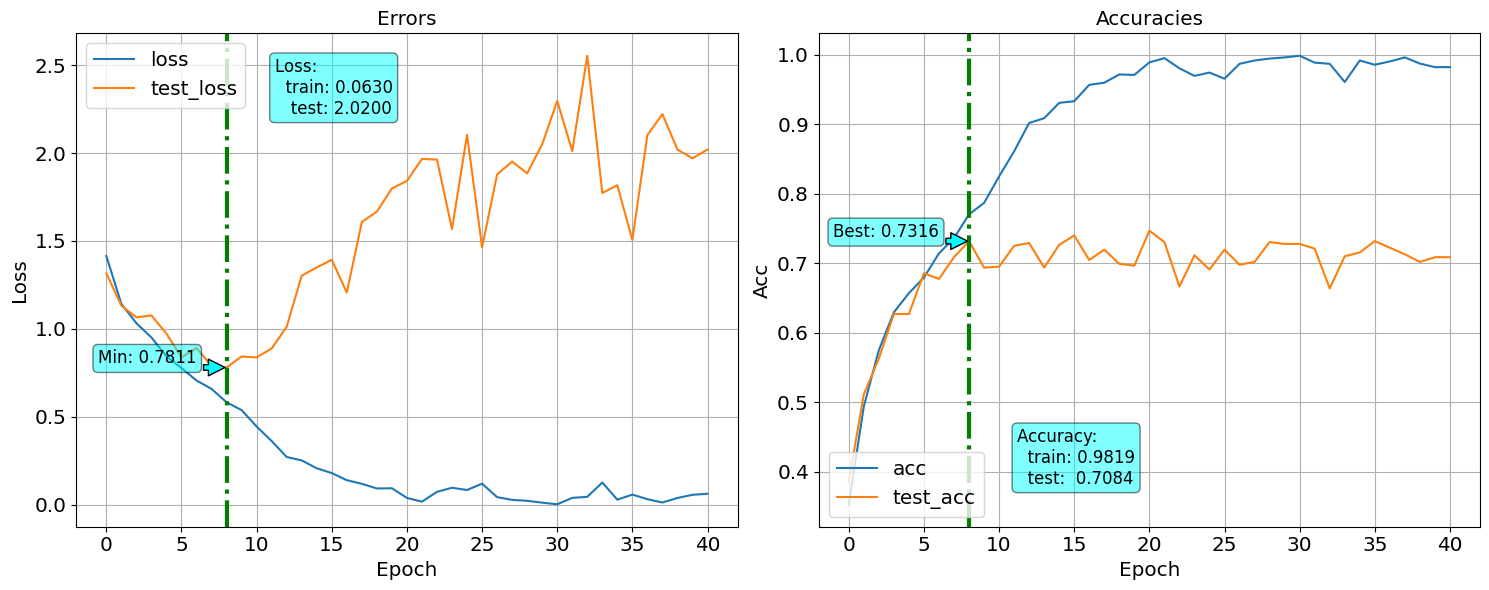

In [28]:
plot_torch_hist(loss_df)

## Accuracies

In [29]:
y_pred, y_true = [], []

###-------------
### Train dataset
###-------------
for data in train_dataloader:
    # get input data
    X_train, y_train = data
    X_train = X_train.to(device)

    y_true.extend(y_train)

    # make predictions
    pred_out = model(X_train)
    _, pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

    # move over to cpu
    #y_train = y_train# .cpu()
    pred = pred.data.cpu()

    y_pred.extend(pred)


print ('Training accuracy : {:.4f}'.format(accuracy_score(y_true, y_pred)))

Training accuracy : 0.9891


In [30]:
accuracy_score(y_true, y_pred)

0.989100817438692

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       718
           2       1.00      0.97      0.99       523
           3       0.99      0.99      0.99       561
           4       0.98      1.00      0.99       634

    accuracy                           0.99      2936
   macro avg       0.99      0.99      0.99      2936
weighted avg       0.99      0.99      0.99      2936



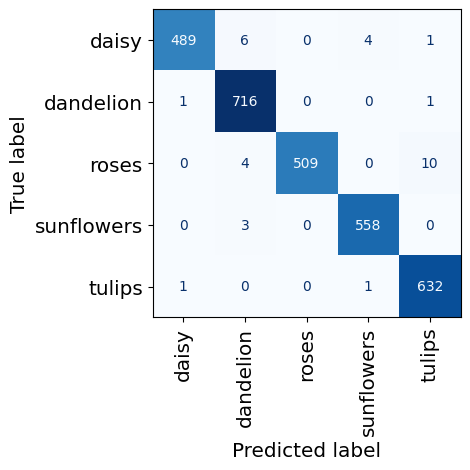

In [32]:
cm  = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [33]:
###-------------
### Test dataset
###-------------
y_pred, y_true = [], []

for data in test_dataloader:
    # get input data
    X_test, y_test = data
    X_test = X_test.to(device)

    y_true.extend(y_test)

    # make predictions
    pred_out = model(X_test)
    _, pred = torch.max(pred_out, 1) # max along an axis gives both max val as well as index

    # move over to cpu
    #y_train = y_train# .cpu()
    pred = pred.data.cpu()

    y_pred.extend(pred)


print ('Training accuracy : {:.4f}'.format(accuracy_score(y_true, y_pred)))

Training accuracy : 0.7084


In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       133
           1       0.71      0.77      0.74       180
           2       0.70      0.44      0.54       118
           3       0.79      0.80      0.79       138
           4       0.63      0.75      0.69       165

    accuracy                           0.71       734
   macro avg       0.71      0.70      0.70       734
weighted avg       0.71      0.71      0.70       734



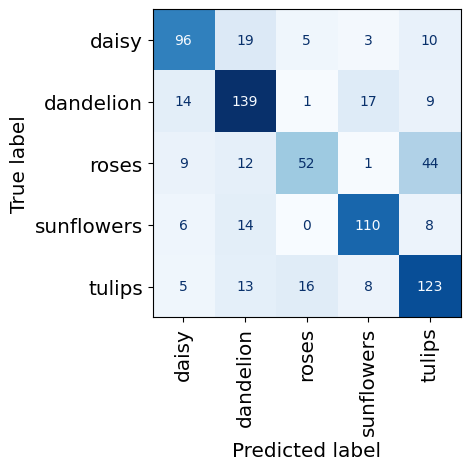

In [35]:
cm  = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();